In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from scipy.linalg import expm, logm
from numpy.linalg import matrix_power
import pygsti

#setup autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
SigX = np.array([[0, 1], [1, 0]])
SigY = np.array([[0, -1j], [1j, 0]])
SigZ = np.array([[1, 0], [0, -1]])
SigI = np.eye(2)

def commutator(A, B):
    return A @ B - B @ A

check_commutator = lambda A, B: np.allclose(commutator(A, B), 0)

PauliBasis_1Q = [SigI, SigX, SigY, SigZ]
PauliBasis_2Q = [np.kron(A, B) for A in PauliBasis_1Q for B in PauliBasis_1Q]

In [9]:
def su4_from_vector(x):
    H = np.zeros((4, 4), dtype=np.complex128)
    for idx in range(15):
        H += x[idx] * PauliBasis_2Q[idx+1]
    return H

def SU4_from_vector(x):
    return expm(-(1j/2) * su4_from_vector(x))

def vector_from_su4(H):
    coefs = np.array([np.trace(H @ P)/4 for P in PauliBasis_2Q[1:]])
    assert coefs.imag.max() < 1e-10
    return coefs.real

def vector_from_SU4(U):
    return vector_from_su4(2j * logm(U))

In [10]:
def parse_su4_vector(x):
    return {
        'IX': x[0],
        'IY': x[1],
        'IZ': x[2],
        'XI': x[3],
        'XX': x[4],
        'XY': x[5],
        'XZ': x[6],
        'YI': x[7],
        'YX': x[8],
        'YY': x[9],
        'YZ': x[10],
        'ZI': x[11],
        'ZX': x[12],
        'ZY': x[13],
        'ZZ': x[14],
    }

def idx_to_pauli_string(idx):
    return ['I', 'X', 'Y', 'Z'][idx//4] + ['I', 'X', 'Y', 'Z'][idx%4]

def plot_su4_vector(x):
    plt.bar(parse_su4_vector(x).keys(), parse_su4_vector(x).values())

In [11]:
def make_Adjoint_SU4(U):
    lop = np.zeros((15, 15), dtype=complex)
    for i, op_i in enumerate(PauliBasis_2Q[1:]):
        for j, op_j in enumerate(PauliBasis_2Q[1:]):
            lop[i, j] = np.trace(op_i @ U @ op_j @ np.linalg.inv(U))/4
    return lop.real

def find_adjoint_order(Ad):
    # find the first power of the adjoint that is the identity
    for i in range(1, 100):
        if np.allclose(matrix_power(Ad, i), np.eye(15)):
            return i
    raise ValueError("Adjoint order not found")
    return None

def make_Adjoint_projector(U):
    Ad = make_Adjoint_SU4(U)
    order = find_adjoint_order(Ad)
    Pi = np.zeros((15, 15), dtype=float)
    for i in range(order):
        Pi += matrix_power(Ad, i)
    return Pi/order


# Define a pygsti model

In [44]:
def make_pygsti_model(x_su4, pauli_gate_depolarization=0., signal_gate_depolarization=0.0, spam_depolarization=0.):
    model = pygsti.models.modelconstruction.create_explicit_model_from_expressions(['Q0', 'Q1'],
        [('Gx', 'Q0'), ('Gy', 'Q0'), ('Gz', 'Q0'), ('Gx', 'Q1'), ('Gy', 'Q1'), ('Gz', 'Q1'),], 
        [ "X(pi,Q0)", "Y(pi,Q0)", "Z(pi,Q0)", "X(pi,Q1)", "Y(pi,Q1)", "Z(pi,Q1)"]) 
    # add depolarization
    model.depolarize(op_noise=pauli_gate_depolarization, spam_noise=spam_depolarization)

    # add the signal gate
    S = SU4_from_vector(x_su4)
    
    model.operations['Gsignal', 'Q0', 'Q1'] = pygsti.unitary_to_pauligate(S)


    return model

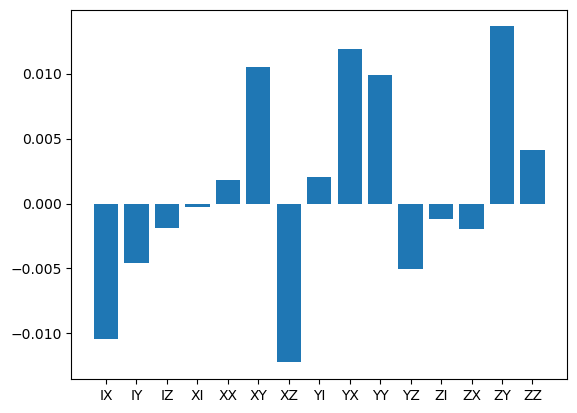

In [45]:
x_vec = 0.01*np.random.randn(15)
plot_su4_vector(x_vec)

In [46]:
model = make_pygsti_model(x_vec)

# Construct Pauli projection operators


In [47]:
projectors = [make_Adjoint_projector(U) for U in PauliBasis_2Q[1:]]

# identify projection triplets

In [53]:
diag_matrix_units = [np.zeros((15, 15), dtype=float) for _ in range(15)]
for idx, P in enumerate(projectors):
    diag_matrix_units[idx][idx, idx] = 1

# create all triplets of the projector indices
triplets = []
for idx in range(15):
    for jdx in range(15):
        for kdx in range(15):
            if idx != jdx and idx != kdx and jdx != kdx:
                triplets.append((idx, jdx, kdx))

# find the triplets that project onto diagonal matrices
triplets_found = dict()
for t1, t2, t3 in triplets:
    P = projectors[t1] @ projectors[t2] @ projectors[t3]
    for unit in diag_matrix_units:
        if np.allclose(P, unit):
            diag_vec = np.diag(unit)
            if tuple(diag_vec) not in triplets_found:
                triplets_found[tuple(diag_vec)] = (t1, t2, t3)
            if len(triplets_found) == 15:
                break

In [54]:
triplets

[(0, 1, 2),
 (0, 1, 3),
 (0, 1, 4),
 (0, 1, 5),
 (0, 1, 6),
 (0, 1, 7),
 (0, 1, 8),
 (0, 1, 9),
 (0, 1, 10),
 (0, 1, 11),
 (0, 1, 12),
 (0, 1, 13),
 (0, 1, 14),
 (0, 2, 1),
 (0, 2, 3),
 (0, 2, 4),
 (0, 2, 5),
 (0, 2, 6),
 (0, 2, 7),
 (0, 2, 8),
 (0, 2, 9),
 (0, 2, 10),
 (0, 2, 11),
 (0, 2, 12),
 (0, 2, 13),
 (0, 2, 14),
 (0, 3, 1),
 (0, 3, 2),
 (0, 3, 4),
 (0, 3, 5),
 (0, 3, 6),
 (0, 3, 7),
 (0, 3, 8),
 (0, 3, 9),
 (0, 3, 10),
 (0, 3, 11),
 (0, 3, 12),
 (0, 3, 13),
 (0, 3, 14),
 (0, 4, 1),
 (0, 4, 2),
 (0, 4, 3),
 (0, 4, 5),
 (0, 4, 6),
 (0, 4, 7),
 (0, 4, 8),
 (0, 4, 9),
 (0, 4, 10),
 (0, 4, 11),
 (0, 4, 12),
 (0, 4, 13),
 (0, 4, 14),
 (0, 5, 1),
 (0, 5, 2),
 (0, 5, 3),
 (0, 5, 4),
 (0, 5, 6),
 (0, 5, 7),
 (0, 5, 8),
 (0, 5, 9),
 (0, 5, 10),
 (0, 5, 11),
 (0, 5, 12),
 (0, 5, 13),
 (0, 5, 14),
 (0, 6, 1),
 (0, 6, 2),
 (0, 6, 3),
 (0, 6, 4),
 (0, 6, 5),
 (0, 6, 7),
 (0, 6, 8),
 (0, 6, 9),
 (0, 6, 10),
 (0, 6, 11),
 (0, 6, 12),
 (0, 6, 13),
 (0, 6, 14),
 (0, 7, 1),
 (0, 7, 2),
 (0, 7, 3)

In [56]:
def index_to_pauli_string(idx):
    diag_vec = np.zeros(15)
    diag_vec[idx] = 1
    parsed_dict = parse_su4_vector(diag_vec)
    return ' '.join([key for key, val in parsed_dict.items() if val != 0])

def diag_vec_to_pauli_string(diag_vec):
    return ' '.join([index_to_pauli_string(idx) for idx, val in enumerate(diag_vec) if val != 0])

pauli_projector_triplets = {}
for diag_vec, triplet in triplets_found.items():
    pauli_projector_triplets[diag_vec_to_pauli_string(diag_vec)] = [index_to_pauli_string(idx) for idx in triplet]

In [57]:
pauli_projector_triplets

{'XI': ['IX', 'IY', 'XI'],
 'YI': ['IX', 'IY', 'YI'],
 'ZI': ['IX', 'IY', 'ZI'],
 'IX': ['IX', 'XI', 'YI'],
 'XX': ['IX', 'XI', 'YY'],
 'YX': ['IX', 'XY', 'YI'],
 'ZX': ['IX', 'XY', 'YY'],
 'IY': ['IY', 'XI', 'YI'],
 'XY': ['IY', 'XI', 'YX'],
 'YY': ['IY', 'XX', 'YI'],
 'ZY': ['IY', 'XX', 'YX'],
 'IZ': ['IZ', 'XI', 'YI'],
 'XZ': ['IZ', 'XI', 'YX'],
 'YZ': ['IZ', 'XX', 'YI'],
 'ZZ': ['IZ', 'XX', 'YX']}

# Identify the in-phase and quadrature state-preparations

In [58]:
from pygsti import sigmaii, sigmaix, sigmaiy, sigmaiz, sigmaxi, sigmaxx, sigmaxy, sigmaxz, sigmayi, sigmayx, sigmayy, sigmayz, sigmazi, sigmazx, sigmazy, sigmazz

In [59]:
np.linalg.eig(sigmaxx)

(array([ 1., -1.,  1., -1.]),
 array([[ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.70710678, -0.70710678],
        [ 0.        ,  0.        ,  0.70710678,  0.70710678],
        [ 0.70710678, -0.70710678, -0.        ,  0.        ]]))

In [60]:
np.linalg.eig(sigmaxy)

(array([ 1.+0.j, -1.+0.j,  1.+0.j, -1.+0.j]),
 array([[-0.        -0.70710678j,  0.70710678+0.j        ,
          0.        +0.j        ,  0.        +0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
          0.70710678+0.j        ,  0.70710678+0.j        ],
        [ 0.        +0.j        ,  0.        +0.j        ,
         -0.        -0.70710678j,  0.        +0.70710678j],
        [ 0.70710678+0.j        ,  0.        -0.70710678j,
          0.        +0.j        ,  0.        +0.j        ]]))

In [61]:
np.linalg.eig(sigmaix)

(array([ 1., -1.,  1., -1.]),
 array([[ 0.70710678, -0.70710678,  0.        ,  0.        ],
        [ 0.70710678,  0.70710678,  0.        ,  0.        ],
        [ 0.        , -0.        ,  0.70710678, -0.70710678],
        [ 0.        , -0.        ,  0.70710678,  0.70710678]]))

In [96]:
import numpy as np
from qutip import Qobj, ptrace, entropy_vn

def is_entangled(state_vector):
  """
  Checks if a state vector is entangled using QuTiP.

  Args:
    state_vector: A NumPy array representing the state vector.

  Returns:
    True if entangled, False otherwise.
  """

  # Convert the state vector to a QuTiP Qobj
  qobj_state = Qobj(state_vector)

  # Calculate the reduced density matrix for one of the subsystems
  reduced_rho = ptrace(qobj_state, [0])  # Trace out the second subsystem

  # Calculate the Von Neumann entropy of the reduced density matrix
  entropy = entropy_vn(reduced_rho)

  # If the entropy is greater than 0, the state is entangled
  if entropy > 0:
    return True
  else:
    return False

In [97]:
# for each Pauli matrix in SU4, there will be two eigenvalues that are 1 and two that are -1
# find these 
pauli = sigmayx
eigvals, eigvecs = np.linalg.eig(pauli)
pos_eigvecs = eigvecs[:, np.isclose(eigvals, 1)].T
neg_eigvecs = eigvecs[:, np.isclose(eigvals, -1)].T

# now, find the 4 possible of positive and negative eigenvectors
inphase_pairs = []
quadrature_pairs = []
for pos_eigvec in pos_eigvecs:
    for neg_eigvec in neg_eigvecs:
        inphase_pairs.append((pos_eigvec + neg_eigvec)/np.sqrt(2))
        quadrature_pairs.append((pos_eigvec + 1j*neg_eigvec)/np.sqrt(2))


In [98]:
pos_eigvecs

array([[-0.        -0.70710678j,  0.        +0.j        ,
         0.        +0.j        ,  0.70710678+0.j        ],
       [ 0.        +0.j        ,  0.70710678+0.j        ,
         0.        +0.70710678j,  0.        +0.j        ]])

In [99]:
quadrature_pairs

[array([0.+7.85046229e-17j, 0.+0.00000000e+00j, 0.+0.00000000e+00j,
        1.+0.00000000e+00j]),
 array([0. -0.5j, 0. +0.5j, 0.5+0.j , 0.5+0.j ]),
 array([0. +0.5j, 0.5+0.j , 0. +0.5j, 0.5+0.j ]),
 array([0. +0.j , 0.5+0.5j, 0.5+0.5j, 0. +0.j ])]

In [105]:
print(is_entangled(inphase_pairs[1]))

False


In [110]:
print([is_entangled(p) for p in inphase_pairs])

[True, False, True, True]


In [111]:
print([is_entangled(p) for p in quadrature_pairs])

[True, True, True, True]


In [133]:
def model_CZ(x):
    generator = np.zeros((4, 4), dtype=complex)
    generator += (np.pi/2)*(pauli_basis_2q[3] + pauli_basis_2q[12]) - np.pi/2*(pauli_basis_2q[15] + pauli_basis_2q[0])
    for i in range(15):
        generator += x[i]*pauli_basis_2q[i+1]
    return expm(-(1j/2)*generator)

def make_zxzxz_unitary_1q(phases):
    u = np.eye(2)
    u = expm(-1j*phases[0]*SigZ/2) @ u
    u = expm(-1j*np.pi*SigX/4) @ u
    u = expm(-1j*phases[1]*SigZ/2) @ u
    u = expm(-1j*np.pi*SigX/4) @ u
    u = expm(-1j*phases[2]*SigZ/2) @ u
    return u

def kak_prep_synthesis(target_state):
    """
    Synthesize a preparation circuit for a target state
    using the KAK decomposition
    """
    

def separable_prep_cost(phases, target_state):
    U_Q1 = make_zxzxz_unitary_1q(phases[0:3])
    U_Q2 = make_zxzxz_unitary_1q(phases[3:6])
    U = np.kron(U_Q1, U_Q2)
    U_prep = U@np.array([1, 0, 0, 0])
    return 1 - abs(np.dot(U_prep.conj().T, target_state))**2

def entangled_state_cost(phases, target_state):
    target_cz = model_CZ(np.zeros(15))
    U_Q1_1 = make_zxzxz_unitary_1q(phases[0:3])
    U_Q2_1 = make_zxzxz_unitary_1q(phases[3:6])
    K_1 = np.kron(U_Q1_1, U_Q2_1)
    U_Q1_2 = make_zxzxz_unitary_1q(phases[6:9])
    U_Q2_2 = make_zxzxz_unitary_1q(phases[9:12])
    K_2 = np.kron(U_Q1_2, U_Q2_2)
    U = K_2 @ target_cz @ K_1
    prep_from_U = U @ np.array([1, 0, 0, 0])
    return 1 - abs(np.dot(prep_from_U.conj().T, target_state))**2

def double_cz_gate_state_prep_cost(phases, target_state):
    target_cz = model_CZ(np.zeros(15))
    U_Q1_1 = make_zxzxz_unitary_1q(phases[0:3])
    U_Q2_1 = make_zxzxz_unitary_1q(phases[3:6])
    K_1 = np.kron(U_Q1_1, U_Q2_1)
    U_Q1_2 = make_zxzxz_unitary_1q(phases[6:9])
    U_Q2_2 = make_zxzxz_unitary_1q(phases[9:12])
    K_2 = np.kron(U_Q1_2, U_Q2_2)
    U_Q1_3 = make_zxzxz_unitary_1q(phases[12:15])
    U_Q2_3 = make_zxzxz_unitary_1q(phases[15:18])
    K_3 = np.kron(U_Q1_2, U_Q2_2)
    U = K_2 @ target_cz @ K_1 @ target_cz @ K_3
    prep_from_U = U @ np.array([1, 0, 0, 0])
    return 1 - abs(np.dot(prep_from_U.conj().T, target_state))**2


def find_preparation_circuit(target_state):
    """
    Find a circuit that prepares a target state

    use an optimization algorithm to find the best,
    bound the phases between [0, 2pi]
    """
    from scipy.optimize import minimize
    if is_entangled(target_state) is False:
        bounds = [(0, 2*np.pi) for i in range(6)]
        res = minimize(separable_prep_cost, np.random.rand(6), args=(target_state), bounds=bounds)
    else:
        bounds = [(0, 2*np.pi) for i in range(12)]
        res = minimize(entangled_state_cost,  np.random.rand(12), args=(target_state), bounds=bounds)
        if res.fun > 1e-3:
            bounds = [(0, 2*np.pi) for i in range(18)]
            res = minimize(double_cz_gate_state_prep_cost,  np.random.rand(18), args=(target_state), bounds=bounds)
    return res.x, res.fun

In [134]:
find_preparation_circuit(np.array([1, 0, 0, 0]))

(array([0.4817733 , 3.1415929 , 0.4575407 , 0.09209499, 3.14159285,
        0.59664828]),
 2.4868995751603507e-14)